Define TestRunner and TestPlan

In [22]:
import time
import json
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(message)s',level=logging.INFO)

from elasticsearch import Elasticsearch
from clickhouse_driver import Client

class TestRunner:
    def __init__(self, name, config):
        self.name = name
        self.config = config
    
    def run(self, case):
        pass

class ElasticsearchRuner(TestRunner):
    def __init__(self, name, config):
        TestRunner.__init__(self, name, config)
        self.client = Elasticsearch([self.config['cluster']])
        self.indices = self.config['indices']
           
    def run(self, case):
        query = case
        
        logging.debug(f'{self.name} run query {case}')
        start = time.time()
        response = self.client.search(index=self.indices, body=query)
        end = time.time()
        logging.debug(f'{self.name} run query complete')
        
        result = {}
        result['count'] = response['hits']['total']['value']
        result['response'] = response
        result['elapsed'] = end - start
        
        logging.debug(f'query result count {result["count"]} elapsed {result["elapsed"]}')
        return result
        
class ClickhouseRuner(TestRunner):
    def __init__(self, name, config):
        TestRunner.__init__(self, name, config)
        self.client = Client(self.config['cluster'])
    
    def run(self, case):
        query = case
        logging.debug(f'{self.name} run query {case}')
        start = time.time()
        response = self.client.execute(query)
        end = time.time()
        logging.debug(f'{self.name} run query complete')
        
        result = {}
        result['count'] = len(response)
        result['response'] = response
        result['elapsed'] = end - start
        
        logging.debug(f'query result count {result["count"]} elapsed {result["elapsed"]}')
        return result
    
class TestPlan:
    def __init__(self, planfile):
        with open(planfile) as json_file:
            self.plan = json.load(json_file)
            self.targets = []
            for target in self.plan['targets']:
                if target['type'] == 'elasticsearch':
                    runner = ElasticsearchRuner(target['name'], target['config'])
                    self.targets.append(runner)
                elif target['type'] == 'clickhouse':
                    runner = ClickhouseRuner(target['name'], target['config'])
                    self.targets.append(runner)
    
    def run(self):
        reports = []
        for testcase in self.plan['testcases']:
            name, description, cases = testcase
            report = {}
            report['name'] = name
            report['description'] = description
            report['result'] = []
            logging.info(f'run testcase {name} {description}')
            tests = list(zip(self.targets, cases))
            for test in tests:
                runner, query = test
                result = {}
                result['target'] = runner.name
                result['case'] = str(query)
                
                elapsed = []
                for i in range(self.plan['runs']+1):
                    run_result = runner.run(query)
                    elapsed.append(run_result['elapsed'])
                    
                result['elapsed'] = elapsed
                result['elapsed_total'] = sum(elapsed[1:])
                report['result'].append(result)
                
            logging.info(f'run testcase {name} complete')
            reports.append(report)
        return self._summary(reports)
    
    def _summary(self, reports):
        #convert reports data to dataframe
        data = {}
        columns = []

        for report in reports:
            for result in report['result']:
                if 'name' not in data:
                    data['name'] = []
                    columns.append('name')
                data['name'].append(report['name'])
                
                if 'description' not in data:
                    data['description'] = []
                    columns.append('description')
                data['description'].append(report['description'])

                if 'target' not in data:
                    data['target'] = []
                    columns.append('target')
                data['target'].append(result['target'])

                if 'elapsed_total' not in data:
                    data['elapsed_total'] = []
                    columns.append('elapsed_total')
                data['elapsed_total'].append(result['elapsed_total'])

        summary_df = pd.DataFrame (data, columns = columns)
        return summary_df

Sample to run a test query

In [ ]:
clickhouse_config = { "cluster" : "host.docker.internal"} 
clickhouse_runner = ClickhouseRuner('clickhouse', clickhouse_config)

query = 'SELECT * FROM syslog'
clickhouse_runner.run(query)

es_config = { "cluster" : "host.docker.internal", "indices" : "syslog-2021-02-24,syslog-2021-02-25"} 
es_runner = ElasticsearchRuner('es', es_config)

query = {
    "query": {
        "match_all": {}
    }
}
es_runner.run(query)

Run a test plan and show the test result

In [23]:
testplan = TestPlan("testplan.json")
reports = testplan.run()
reports.head()

2021-02-25 19:41:00,984 run testcase case1 query all
2021-02-25 19:41:00,998 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.013s]
2021-02-25 19:41:01,007 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:01,015 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:01,024 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:01,030 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:01,039 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:01,045 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.005s]
2021-02-2

2021-02-25 19:41:01,650 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.009s]
2021-02-25 19:41:01,660 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:01,673 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.011s]
2021-02-25 19:41:01,683 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:01,703 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.017s]
2021-02-25 19:41:01,710 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.005s]
2021-02-25 19:41:01,718 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:01,727 POST http://host.docker.internal:9200/

2021-02-25 19:41:04,011 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:04,020 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:04,028 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:04,040 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.009s]
2021-02-25 19:41:04,052 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.010s]
2021-02-25 19:41:04,065 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.011s]
2021-02-25 19:41:04,081 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.009s]
2021-02-25 19:41:04,095 POST http://host.docker.internal:9200/

2021-02-25 19:41:04,688 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.009s]
2021-02-25 19:41:04,700 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.010s]
2021-02-25 19:41:04,712 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.008s]
2021-02-25 19:41:04,729 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.011s]
2021-02-25 19:41:04,743 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.011s]
2021-02-25 19:41:04,763 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.008s]
2021-02-25 19:41:04,776 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.011s]
2021-02-25 19:41:04,786 POST http://host.docker.internal:9200/

2021-02-25 19:41:06,570 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.014s]
2021-02-25 19:41:06,580 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.009s]
2021-02-25 19:41:06,590 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.009s]
2021-02-25 19:41:06,600 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:06,609 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.008s]
2021-02-25 19:41:06,621 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.009s]
2021-02-25 19:41:06,639 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.015s]
2021-02-25 19:41:06,652 POST http://host.docker.internal:9200/

2021-02-25 19:41:08,103 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:08,113 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.008s]
2021-02-25 19:41:08,118 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.005s]
2021-02-25 19:41:08,125 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.005s]
2021-02-25 19:41:08,131 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.005s]
2021-02-25 19:41:08,137 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.004s]
2021-02-25 19:41:08,145 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:08,151 POST http://host.docker.internal:9200/

2021-02-25 19:41:08,642 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:08,650 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:08,658 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:08,666 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:08,674 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:08,684 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:08,693 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:08,702 POST http://host.docker.internal:9200/

2021-02-25 19:41:10,436 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:10,444 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.005s]
2021-02-25 19:41:10,452 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:10,461 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.007s]
2021-02-25 19:41:10,469 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:10,476 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:10,485 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:10,493 POST http://host.docker.internal:9200/

2021-02-25 19:41:11,011 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.005s]
2021-02-25 19:41:11,022 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.009s]
2021-02-25 19:41:11,036 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.009s]
2021-02-25 19:41:11,044 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:11,051 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:11,060 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:11,068 POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25/_search [status:200 request:0.006s]
2021-02-25 19:41:11,075 POST http://host.docker.internal:9200/

,name,description,target,elapsed_total
0,case1,query all,es1,1.053078
1,case1,query all,clickhouse1,1.696069
2,case2,match all,es1,1.056363
3,case2,match all,clickhouse1,1.134966
4,case3,multi match,es1,1.019245


Show test result in barchart

<AxesSubplot:xlabel='description', ylabel='elapsed_total'>

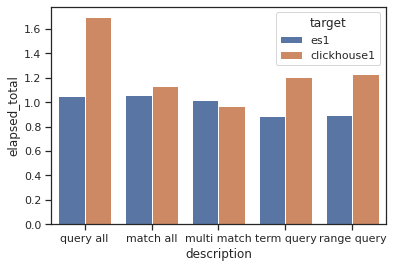

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)
sns.barplot(x="description", y="elapsed_total", hue="target", data=reports)